# Importing libaries

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
# import whisper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import json
import os
import shutil
import time
import zipfile
from IPython.display import HTML, display

# CPU Optimizations

In [4]:
if not torch.cuda.is_available():
    print("Default Configurations:")
    print("Intra-op threads:", torch.get_num_threads())
    print("Inter-op threads:", torch.get_num_interop_threads())
    print()
    print("Updated Configurations:")
    cpu_threads =  os.cpu_count()
    cpu_threads = int(cpu_threads * 0.8) # using 80% of the logical threads
    torch.set_num_threads(cpu_threads)
    torch.set_num_interop_threads(min(8, cpu_threads))
    
    os.environ["OMP_NUM_THREADS"] = str(cpu_threads)
    os.environ["MKL_NUM_THREADS"] = str(cpu_threads)
    os.environ["OPENBLAS_NUM_THREADS"] = str(cpu_threads)
    os.environ["NUMEXPR_NUM_THREADS"] = str(cpu_threads)
    
    print(f"Using {cpu_threads} threads for PyTorch operations.")
    print(f"Intra-op threads={torch.get_num_threads()}")
    print(f"Inter-op threads={torch.get_num_interop_threads()}")

# Configuration Settings for Dataset, Model, and Training Environment

In [5]:
default_save_dir = "/kaggle/working"

pin_memory = True # enable if you have GPU
if torch.cuda.is_available():
    num_workers = 2
    print("yeah, GPU is present")
else:
    num_workers = 8

spec_batch = 64

load_pre_trained_model = False # enable only if the pretrained models are available
pre_trained_dir = "/kaggle/working/"
save_model = True

bert_model = "prajjwal1/bert-mini"
use_multiple_GPUs = True

path = "/kaggle/input/ravdess-emotional-speech-audio/"
save_audio = "/kaggle/working/Data/Audio_data/"
save_spec = "/kaggle/working/Data/Spectrograms/"
save_mfcc = "/kaggle/working/Data/MFCCs/"
os.makedirs(os.path.dirname("/kaggle/working/Data"), exist_ok= True)

yeah, GPU is present


# Directories Generator

The following code makes the directory named "Audio_data", "Spectrograms", "MFCCs".

### Audio_data
All the audio files are copied to this directory, I am bascially getting all the audio files into one directory to access it easily. And before i copy i am making sure that the folder is empty, casue on runnning this notebook multiple times I don't want it to copy the audio files to the same directory.

### Spectrograms
This folder is created to store all the generated spectrograms

### MFCCs
This folder is created to store all the generated MFCCs 


In [6]:
os.makedirs(os.path.dirname(save_spec), exist_ok=True)
os.makedirs(os.path.dirname(save_mfcc), exist_ok=True)
os.makedirs(os.path.dirname(save_audio), exist_ok=True)

Directory = []

for i in range(24):
    if i<9:
        data_path = path + "Actor_0" + str(i+1)
        Directory.append(data_path)
    else:
        data_path = path + "Actor_" + str(i+1)
        Directory.append(data_path)
            
if not os.listdir(save_audio):
    for actor_path in Directory:
        for actor in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, actor)
            shutil.copy(audio_path, save_audio)

# Training and Evaulating Functions

In [7]:
def train (model, device, criterion, optimizer, train_loader, train_epochs = 10, pre_epochs =0, n_outputs = 2):
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    print(f"{'Progress':<14}{'Epoch':<10}{'Loss':<12}{'Accuracy':<16}{'training time per epoch'}")
    train_start = time.time()
    for epoch in range(train_epochs):
        start = time.time()
        model.train()
        total_loss = 0.0
        predicted = []
        target = []
    
        for i, (images, labels) in enumerate(train_loader):
            if i % 10 == 0:
                print(f"\r{(i+1)//10:<16}", end="")

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            if n_outputs == 2:
                outputs, _ = model(images)  # [batch_size, 8]
            else:
                outputs = model(images)  # [batch_size, 8]

            loss = criterion(outputs, labels)  # CrossEntropyLoss expects class indices
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            true = labels.cpu().tolist()

            predicted.extend(preds)
            target.extend(true)
    
        acc = accuracy_score(target, predicted)
        print(f"{pre_epochs + epoch + 1:<6}{total_loss:<14.4f}{acc * 100:.2f}%{time.time() - start:>20.2f} sec")
    seconds = time.time() - train_start
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print("\n")
    print(f"Total Train Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

In [8]:
def eval(model, device, loader, n_outputs = 2):
    model.eval()

    predicted = []
    targets = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            if n_outputs == 2:
                outputs, _ = model(images)  # [batch_size, 8]
            else:
                outputs = model(images)  # [batch_size, 8]
            preds = torch.argmax(outputs, dim=1)            # shape: [batch_size]

            predicted.extend(preds.cpu().tolist())
            targets.extend(labels.cpu().tolist())

    # Evaluation
    accuracy = accuracy_score(predicted, targets)
    cohen_kappa = cohen_kappa_score(predicted, targets)
    mcc = matthews_corrcoef(predicted, targets)
    
    # Macro metrics
    precision_macro = precision_score(predicted, targets, average='macro')
    recall_macro = recall_score(predicted, targets, average='macro')
    f1_macro = f1_score(predicted, targets, average='macro')
    
    # Weighted metrics
    precision_weighted = precision_score(predicted, targets, average='weighted')
    recall_weighted = recall_score(predicted, targets, average='weighted')
    f1_weighted = f1_score(predicted, targets, average='weighted')
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(predicted, targets)
    
    # HTML Table
    html_table = f"""
    <table style="width:50%; border-collapse: collapse; font-size: 16px;">
        <thead>
            <tr>
                <th style="border: 1px solid #ddd; padding: 8px;">Metric</th>
                <th style="border: 1px solid #ddd; padding: 8px;">Macro</th>
                <th style="border: 1px solid #ddd; padding: 8px;">Weighted</th>
            </tr>
        </thead>
        <tbody>
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Accuracy</td>
                <td colspan="2" style="border: 1px solid #ddd; padding: 12px; text-align: center;">
                    <b style="font-size: 18px;">{accuracy*100:.2f}%</b>
                </td>
            </tr>
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Cohen's Kappa</td>
                <td colspan="2" style="border: 1px solid #ddd; padding: 12px; text-align: center;">
                    <b style="font-size: 18px;">{cohen_kappa:.4f}</b>
                </td>
            </tr>
            
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Matthews Corr. Coef. (MCC)</td>
                <td colspan="2" style="border: 1px solid #ddd; padding: 12px; text-align: center;">
                    <b style="font-size: 18px;">{mcc:.4f}</b>
                </td>
            </tr>

            <tr><td style="border: 1px solid #ddd; padding: 8px;">Precision</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{precision_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{precision_weighted*100:.2f}%</td></tr>
    
            <tr><td style="border: 1px solid #ddd; padding: 8px;">Recall</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{recall_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{recall_weighted*100:.2f}%</td>
    
            <tr><td style="border: 1px solid #ddd; padding: 8px;">F1 Score</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{f1_macro*100:.2f}%</td>
                <td style="border: 1px solid #ddd; padding: 8px;">{f1_weighted*100:.2f}%</td></tr>
        </tbody>
    </table>
    """

    
    display(HTML(html_table))
    labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.show()

In [9]:
def save_model_as_zip(model, model_name, save_dir= default_save_dir, zipit = False):
    # File paths
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    zip_path = os.path.join(save_dir, f"{model_name}.zip")

    # Save model
    torch.save(model.state_dict(), model_path)

    if zipit:
        # Zip it
        with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(model_path, arcname=f"{model_name}.pth")
    
        # Remove unzipped .pth file
        os.remove(model_path)

    # Get zipped size in MB
    size_bytes = os.path.getsize(zip_path if zipit else model_path)
    size_mb = size_bytes / (1024 ** 2)

    print(f"{model_name}.zip saved at {zip_path} | Size: {size_mb:.2f} MB")

In [10]:
def load_pretrained_model(model, file_name, device, pre_trained_dir= pre_trained_dir):
    saved_path = os.path.join(pre_trained_dir, file_name)

    try:
        state_dict = torch.load(saved_path, map_location=device)
        model.load_state_dict(state_dict)
        print(f"Model loaded successfully from: {saved_path}")
    except FileNotFoundError:
        print(f"Failed: File not found: {saved_path}")
    except RuntimeError as e:
        print(f"Failed: State dict mismatch: {e}")
    except Exception as e:
        print(f"Failed: Unexpected error: {e}")


# Image DataLoader

In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, labels, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.labels = labels
        self.filenames = list(labels.keys())
        if self.transform is None:
            self.transform = transforms.Compose([
                                transforms.Resize((64, 64)),    # Resize images to 64x64 and then
                                transforms.ToTensor()           # Converting it to a PyTorch tensor
                            ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        image_file = self.filenames[index]
        label = self.labels[image_file]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Predicting using Spectrograms

## Spectrogram Generator
A function to generate the spectrogram, when the audio file location and the save location is given.

In [12]:
def Spectrograms_generator(audio_path, save_path, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24))  # size fits CNN input nicely
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')  # no axis for CNN input
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    # plt.show()

In [13]:
for audio in os.listdir(save_audio):
    name = audio.split(".")
    Save_path = save_spec + name[0] + ".png"
    file_path = save_audio + audio
    
    Spectrograms_generator(file_path, Save_path)


## Data Augmentation

### Simulation of Minor Time shifts and Frequency shifts

In [17]:
spatial_shift_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor()
])

### Simulation of Variablity in Intensity/ Noice Addition

In [18]:
Variational_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

### Simulation of Signal Dropouts/Occlusion

In [19]:
random_erasure_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08)),
])

### Clean Transformation/ No Augmentation

In [20]:
clean_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

## Train, Dev, Test Split

In [21]:
random_state=42

# Extracting labels from filenames
labels = {}
for filename in os.listdir(save_spec):
    if filename.endswith(".png"):
        label = int(filename.split("-")[2]) - 1
        labels[filename] = label

filenames = list(labels.keys())

train_files, temp_files = train_test_split(filenames, test_size=0.2, random_state=random_state, shuffle=True)
dev_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=random_state, shuffle=True)

# Creating label dicts for train, dev and test sets
train_labels = {fname: labels[fname] for fname in train_files}
dev_labels = {fname: labels[fname] for fname in dev_files}
test_labels = {fname: labels[fname] for fname in test_files}

## Train Dataset and Augmented Datset

In [22]:
spec_clean_dataset = ImageDataset(
    image_dir= save_spec,
    labels=train_labels,
    transform=clean_transform
)

spec_spatial_dataset = ImageDataset(
    image_dir= save_spec,
    labels=train_labels,
    transform = spatial_shift_transform
)

spec_var_dataset = ImageDataset(
    image_dir= save_spec,
    labels=train_labels,
    transform = Variational_transform
)

spec_erase_dataset = ImageDataset(
    image_dir= save_spec,
    labels=train_labels,
    transform = random_erasure_transform
)

## Spectrogram DataLoaders

In [23]:
spec_clean_dataloader= DataLoader(spec_clean_dataset, batch_size= spec_batch, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

spec_combined_dataset = ConcatDataset([spec_clean_dataset, spec_spatial_dataset, spec_var_dataset, spec_erase_dataset])
spec_aug_dataloader = DataLoader(spec_combined_dataset, batch_size= spec_batch, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


spec_dev_dataset = ImageDataset(image_dir=save_spec, labels=dev_labels)
spec_dev_dataloader = DataLoader(spec_dev_dataset, batch_size= spec_batch)

spec_test_dataset = ImageDataset(image_dir=save_spec, labels=test_labels)
spec_test_dataloader = DataLoader(spec_test_dataset, batch_size= spec_batch)

## Spec_CNN Model - 0

In [24]:
class Spec_CNN_0(nn.Module):
    def __init__(self, classes=8):
        
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # Output is of the form [16, 64, 64]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # Output is of the form [32, 32, 32]

        self.fc1 = nn.Linear(in_features = 32 * 16 * 16, out_features = 128)
        self.fc2 = nn.Linear(in_features = 128, out_features = classes )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # (B,16,32,32)
        x = self.pool(F.relu(self.conv2(x)))    # (B,32,16,16)
        x = x.view(x.size(0), -1)               # (B,16,32,32) -> (B,8192)
        features = F.relu(self.fc1(x))          # (B,8192)
        logits = self.fc2(features)             # (B, 8)
        return logits, features

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

### Training Spec_CNN_0 on Clean Data

In [33]:
model_0 = Spec_CNN_0(classes=8)
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [34]:
if not load_pre_trained_model:
    train(model_0, device, criterion, optimizer_0, spec_clean_dataloader, train_epochs =40, pre_epochs = 0)
else:
    load_pretrained_model(model_0, filename = "spec_0", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
1               1     36.9984       17.88%                1.38 sec
1               2     34.1768       29.77%                1.38 sec
1               3     30.9494       36.11%                1.61 sec
1               4     28.1574       41.58%                1.57 sec
1               5     25.4883       47.48%                1.40 sec
1               6     22.6551       55.12%                1.38 sec
1               7     21.2390       56.60%                1.42 sec
1               8     19.0757       61.98%                1.40 sec
1               9     18.0479       63.28%                1.39 sec
1               10    15.4391       70.57%                1.38 sec
1               11    14.0239       73.26%                1.38 sec
1               12    12.8501       75.00%                1.39 sec
1               13    10.6004       81.08%                1.36 sec
1               14    9.3710        82.

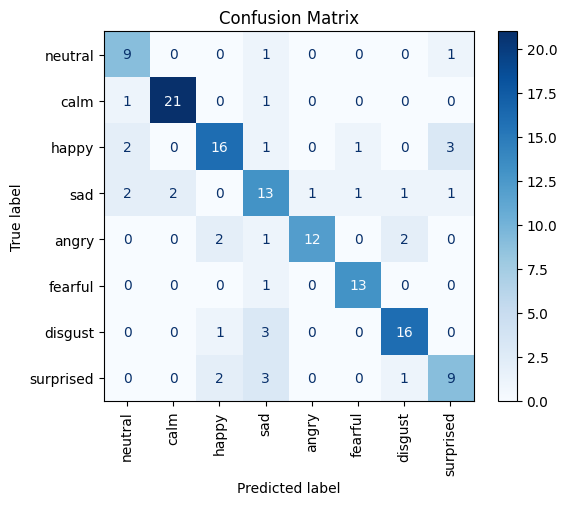

In [36]:
eval(model_0, device, spec_dev_dataloader)

In [45]:
if save_model:
    save_model_as_zip(model_0, "spec_0")

spec_0.zip saved at /kaggle/working/spec_0.zip | Size: 4.03 MB


### Training Spec_CNN_0 on Augmented Data

In [40]:
model_1 = Spec_CNN_0(classes=8)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [41]:
if not load_pre_trained_model:
    train(model_1, device, criterion, optimizer_1, spec_aug_dataloader, train_epochs =40, pre_epochs = 0)
else:
    load_pretrained_model(model_0, filename = "spec_1", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
7               1     129.7114      31.25%                5.33 sec
7               2     97.7279       50.91%                5.25 sec
7               3     75.1010       63.52%                5.80 sec
7               4     59.4239       71.01%                5.26 sec
7               5     47.2978       77.47%                5.35 sec
7               6     39.5090       82.14%                5.37 sec
7               7     34.1593       84.90%                5.29 sec
7               8     27.8167       87.78%                5.37 sec
7               9     24.9472       88.91%                5.74 sec
7               10    20.8100       91.41%                5.36 sec
7               11    18.7575       91.86%                5.27 sec
7               12    17.2469       93.16%                5.33 sec
7               13    15.3379       93.53%                5.25 sec
7               14    14.9768       93.

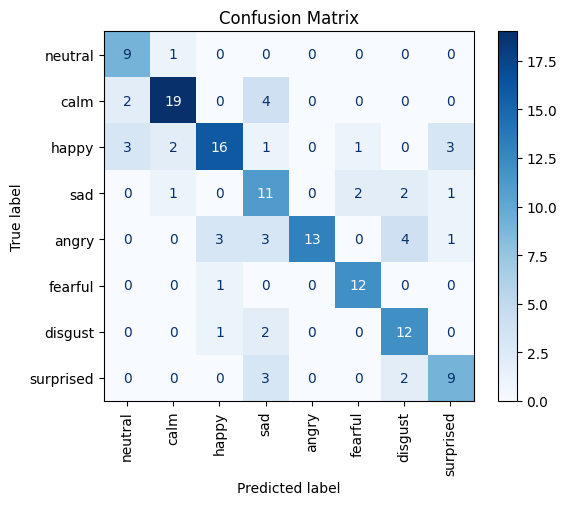

In [43]:
eval(model_1, device, spec_dev_dataloader)

In [52]:
if save_model:
    save_model_as_zip(model_1, "spec_1")

spec_1.zip saved at /kaggle/working/spec_1.zip | Size: 4.03 MB


## Spec_CNN_1

In [46]:
class Spec_CNN_1(nn.Module):
    def __init__(self, classes=8):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # (B,16,64,64)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # (B,32,32,32)
        self.bn2 = nn.BatchNorm2d(32)

        self.proj = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1)
        self.bn_proj = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=classes, bias=True)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))   # (B,16,64,64)
        x1_pooled = self.pool(x1)              # (B,16,32,32)
        
        x2 = F.relu(self.bn2(self.conv2(x1_pooled)))  # (B,32,32,32)
        x1_proj = self.bn_proj(self.proj(x1_pooled))  # (B,32,32,32)
        x_res = self.pool(x2 + x1_proj)               # (B,32,16,16)

        x_flat = x_res.view(x_res.size(0), -1)        # (B, 32*16*16)
        x_flat = self.dropout(x_flat)
        features = F.relu(self.bn_fc1(self.fc1(x_flat)))  # (B, 128)
        logits = self.fc2(features)

        return logits, features

### Training Spec_CNN on Clean Data

In [54]:
model_2 = Spec_CNN_1(classes=8)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [55]:
if not load_pre_trained_model:
    train(model_2, device, criterion, optimizer_2,spec_clean_dataloader, train_epochs =30, pre_epochs = 0)
else:
    load_pretrained_model(model_2, filename = "spec_2", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
1               1     28.6767       43.06%                1.40 sec
1               2     19.6517       66.49%                1.46 sec
1               3     14.3019       78.30%                1.40 sec
1               4     10.3293       87.15%                1.40 sec
1               5     7.3817        92.10%                1.40 sec
1               6     5.2945        95.05%                1.41 sec
1               7     3.8147        97.74%                1.40 sec
1               8     2.9472        97.83%                1.45 sec
1               9     2.0816        98.96%                1.45 sec
1               10    1.7531        99.05%                1.40 sec
1               11    1.4138        99.39%                1.41 sec
1               12    1.0945        99.65%                1.45 sec
1               13    1.0208        99.65%                1.41 sec
1               14    0.9798        99.

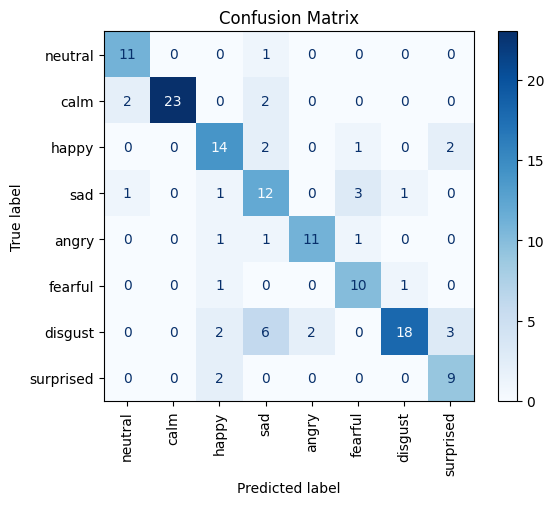

In [56]:
eval(model_2, device, spec_dev_dataloader)

In [57]:
if save_model:
    save_model_as_zip(model_2, "spec_2")

spec_2.zip saved at /kaggle/working/spec_2.zip | Size: 4.04 MB


### Training Spec_CNN - 1 on Augmented Data

In [59]:
model_3 = Spec_CNN_1(classes=8)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [61]:
if not load_pre_trained_model:
    train(model_3, device, criterion, optimizer_3,spec_aug_dataloader, train_epochs =30, pre_epochs = 0)
else:
    load_pretrained_model(model_3, filename = "spec_3", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
7               1     83.0805       60.96%                5.36 sec
7               2     39.4956       84.94%                5.44 sec
7               3     26.3648       89.87%                5.41 sec
7               4     21.0080       91.64%                5.40 sec
7               5     17.5949       92.56%                5.44 sec
7               6     15.5572       93.34%                5.75 sec
7               7     14.3677       94.08%                5.47 sec
7               8     13.1815       94.08%                5.36 sec
7               9     11.3070       95.36%                5.36 sec
7               10    11.4030       95.14%                5.37 sec
7               11    9.4078        95.70%                5.35 sec
7               12    9.2316        95.86%                5.78 sec
7               13    9.7734        95.42%                5.39 sec
7               14    8.8119        96.

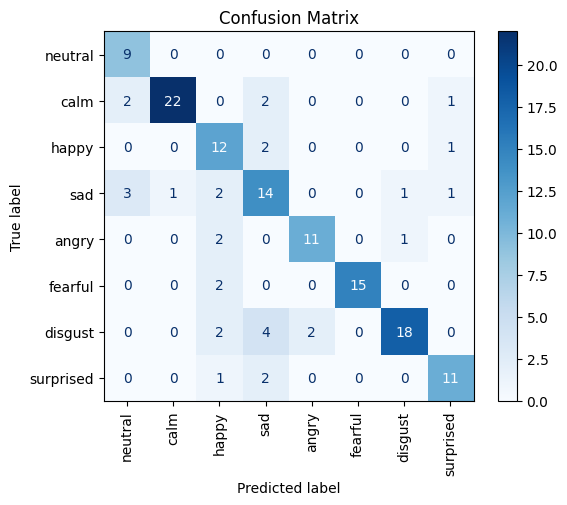

In [63]:
eval(model_3, device, spec_dev_dataloader)

In [84]:
if save_model:
    save_model_as_zip(model_3, "spec_3")

spec_3.zip saved at /kaggle/working/spec_3.zip | Size: 4.04 MB


## Using Pre Trained ResNet18

In [69]:
model_4 = resnet18(pretrained=True)

# Freeze early layers
# for param in model_2.parameters():
#     param.requires_grad = False

# Replacing the classifier head
num_features = model_4.fc.in_features
model_4.fc = nn.Linear(num_features, 8, bias= True)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=1e-3)

In [70]:
if not load_pre_trained_model:
    train(model_4, device, criterion, optimizer_4, spec_clean_dataloader, train_epochs =30, pre_epochs = 0, n_outputs =1)
else:
    load_pretrained_model(model_4, filename = "spec_4", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
1               1     30.5419       42.71%                1.62 sec
1               2     17.4333       66.15%                1.69 sec
1               3     9.0233        82.81%                1.68 sec
1               4     6.1220        88.02%                1.64 sec
1               5     6.3845        87.50%                1.65 sec
1               6     5.3600        89.15%                1.70 sec
1               7     3.7481        91.93%                1.63 sec
1               8     2.2454        96.18%                1.66 sec
1               9     1.8098        96.70%                1.67 sec
1               10    2.9384        94.88%                1.60 sec
1               11    3.5445        93.49%                1.65 sec
1               12    1.8367        96.53%                1.84 sec
1               13    1.8587        96.79%                1.84 sec
1               14    2.0924        96.

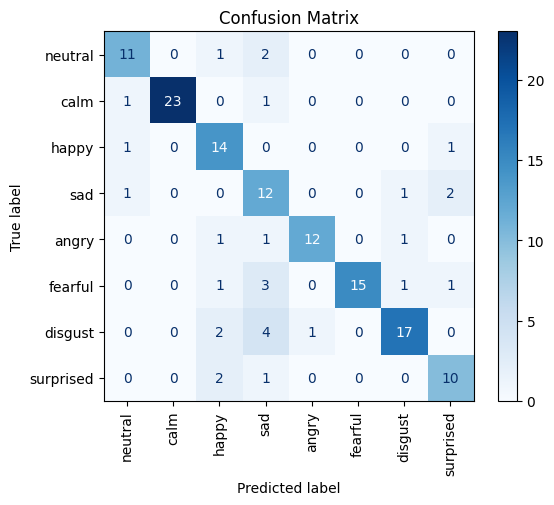

In [72]:
eval(model_4, device, spec_dev_dataloader, n_outputs = 1)

In [83]:
if save_model:
    save_model_as_zip(model_4, "spec_4")

spec_4.zip saved at /kaggle/working/spec_4.zip | Size: 42.72 MB


In [78]:
model_5 = resnet18(pretrained=True)

# Freeze early layers
# for param in model_2.parameters():
#     param.requires_grad = False

# Replacing the classifier head
num_features = model_5.fc.in_features
model_5.fc = nn.Linear(num_features, 8, bias= True)
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=1e-3)

In [79]:
if not load_pre_trained_model:
    train(model_5, device, criterion, optimizer_5, spec_aug_dataloader, train_epochs =30, pre_epochs = 0, n_outputs =1)
else:
    load_pretrained_model(model_5, filename = "spec_5", device= device)

Using 2 GPUs!
Progress      Epoch     Loss        Accuracy        training time per epoch
7               1     76.6018       63.09%                6.20 sec
7               2     29.5531       86.02%                6.31 sec
7               3     18.7862       91.25%                6.26 sec
7               4     15.6047       92.88%                6.61 sec
7               5     12.0212       94.81%                6.26 sec
7               6     12.6161       94.29%                6.22 sec
7               7     7.3145        96.66%                6.21 sec
7               8     9.1899        95.79%                6.27 sec
7               9     6.5129        97.07%                6.74 sec
7               10    5.9784        97.29%                6.25 sec
7               11    7.4903        96.44%                6.28 sec
7               12    8.4094        96.18%                6.26 sec
7               13    4.8807        97.79%                6.24 sec
7               14    3.7998        98.

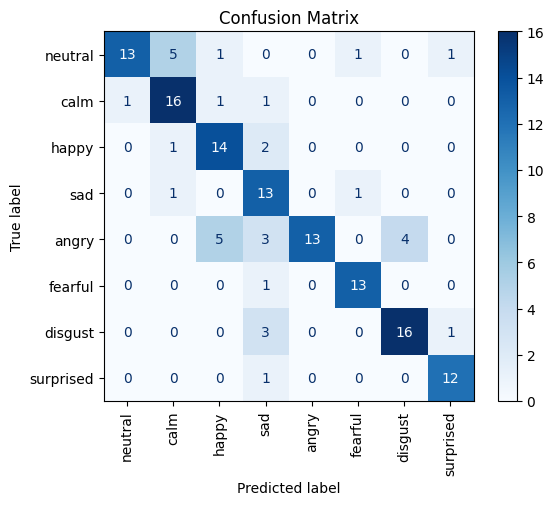

In [81]:
eval(model_5, device, spec_dev_dataloader, n_outputs = 1)

In [82]:
if save_model:
    save_model_as_zip(model_5, "spec_5")

spec_5.zip saved at /kaggle/working/spec_5.zip | Size: 42.72 MB
